<a href="https://colab.research.google.com/github/rubyvanrooyen/notebooks/blob/main/calibration/positions/site_survey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Antenna Position Measurement

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on tiles, and these tiles are placed on site. Once this is done, a survey is needed to refine the positions of each antenna in the array.

Three reference posts are placed. The first is at the centre of the array, the second approximately 2.5 meters due north. The first and second post defines the $y$ axis. The third post is placed approximately 2.5 meters east of the centre, and reasonably close to at right angles to the $y$ axis.

The first reference point, x0, has coordinates (0,0). The second reference point, x1, has coordinates (0, y) and the third is not known, but must be established by measurement.

All measurements are made from the height of the antennas on the reference points.

In [1]:
import numpy as np
from scipy.optimize import minimize 

In [2]:
x0 = [0,0]
x1 = [0, 2209]

### Locating the third reference point

The distances from reference point 2 to the other two reference points (0,1) are measured (in mm)

In [3]:
d_0_2 = 2047
d_1_2 = 3020

Now a least squares estimator is used to work out the x-y coordinates of the third reference point (x2)

In [4]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def f(x):
    return (dist(x0, x) - d_0_2)**2 + (dist(x1, x) - d_1_2)**2

initial_guess = [2047, 0]
res = minimize(f, initial_guess)
x2 = res.x

In [5]:
reference_points = [x1, x0, x2]
reference_points

[[0, 2209], [0, 0], array([2046.96807079,  -11.43277996])]

## Finding the antennas

This is done by measuring the distance from each antenna to the three reference points x0, x1 and x2.

In [6]:
n_ant = 24
m = np.zeros((24,3))

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [7]:
m[0,:] = [1563, 855, 2618]
m[1,:] = [1407, 825, 2355]
m[2,:] = [1750, 765, 2644]
m[3,:] = [839, 1373, 2416]
m[4,:] = [1151, 1422, 2986]
m[5,:] = [842, 1410, 2662]
m[6,:] = [2527, 1119, 929]
m[7,:] = [2274, 1200, 915]
m[8,:] = [2715, 1261, 824]
m[9,:] = [1684, 1064, 1457]
m[10,:] = [2238, 546, 1501]
m[11,:] = [1834, 805, 1493]
m[12,:] = [3320, 1111, 2370]
m[13,:] = [3385, 1192, 2131]
m[14,:] = [3446, 1247, 2555]
m[15,:] = [3063, 1048, 1531]
m[16,:] = [2760, 550, 2096]
m[17,:] = [2873, 784, 1689]
m[18,:] = [2342, 934, 2979]
m[19,:] = [2638, 1142, 3179]
m[20,:] = [2186, 993, 3020]
m[21,:] = [3130, 1260, 3140]
m[22,:] = [2545, 565, 2544]
m[23,:] = [2942, 1000, 2891]

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [8]:
import requests
import json

pos_url = "https://tart.elec.ac.nz/signal/api/v1/imaging/antenna_positions"

def get_data(path):
    server = "https://tart.elec.ac.nz/signal"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

current_pos = get_pos()
current_pos


array([[-0.19674923,  0.8327471 ,  0.        ],
       [ 0.12360839,  0.81634611,  0.        ],
       [-0.32211461,  0.69399004,  0.        ],
       [ 0.52649161,  1.26867907,  0.        ],
       [-0.18824296,  1.40887352,  0.        ],
       [ 0.27140589,  1.38381496,  0.        ],
       [ 1.03271756, -0.43205027,  0.        ],
       [ 1.19082671, -0.15203867,  0.        ],
       [ 1.10280415, -0.61241898,  0.        ],
       [ 0.98202905,  0.41085878,  0.        ],
       [ 0.52663466, -0.14905009,  0.        ],
       [ 0.76807691,  0.24445422,  0.        ],
       [-0.42557857, -1.02654366,  0.        ],
       [-0.15437422, -1.1825475 ,  0.        ],
       [-0.60297545, -1.09132287,  0.        ],
       [ 0.41284895, -0.96467857,  0.        ],
       [-0.16640058, -0.5246445 ,  0.        ],
       [ 0.23353475, -0.74820821,  0.        ],
       [-0.85668069,  0.37191691,  0.        ],
       [-1.12099191,  0.21618772,  0.        ],
       [-0.82195367,  0.5570926 ,  0.   

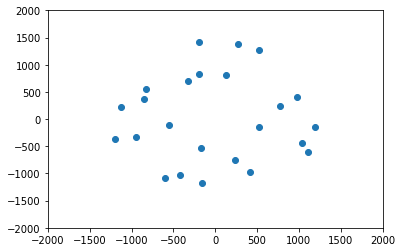

In [9]:
initial_guess = np.zeros(2*n_ant)

for i in range(n_ant):
    initial_guess[2*i:2*i+2] = current_pos[i][0:2]*1000
    #print(current_pos[i][0:2]*1000)
initial_guess

pos_i = current_pos*1000
import matplotlib.pyplot as plt
plt.scatter(pos_i[:,0], pos_i[:,1])
plt.xlim(-2000,2000)
plt.ylim(-2000,2000)
plt.show()

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [10]:
def f(x):
    ret = 0
    for i in range(n_ant):
        for j in range(3):
            p = [x[2*i],x[2*i+1]]
            ret += (dist(reference_points[j], p) - m[i,j])**2
    return ret

print(f(initial_guess))
res = minimize(f, initial_guess)
res

2802680.2420234215


      fun: 32.160056269716144
 hess_inv: array([[ 0.60638175,  0.01882902,  0.62338932, ...,  0.03140986,
        -0.05278726,  0.13546687],
       [ 0.01882902,  0.13862707,  0.00138972, ...,  0.00456083,
         0.0081251 ,  0.05275801],
       [ 0.62338932,  0.00138972,  0.96670481, ..., -0.01449169,
        -0.02947022,  0.18596725],
       ...,
       [ 0.03140986,  0.00456083, -0.01449169, ...,  0.0489794 ,
        -0.03177421,  0.01337536],
       [-0.05278726,  0.0081251 , -0.02947022, ..., -0.03177421,
         0.64014899, -0.17006249],
       [ 0.13546687,  0.05275801,  0.18596725, ...,  0.01337536,
        -0.17006249,  0.73152672]])
      jac: array([ 1.28746033e-05,  2.43186951e-05,  7.15255737e-06, -2.86102295e-06,
        2.86102295e-06, -4.76837158e-07,  2.05039978e-05,  1.14440918e-05,
       -6.19888306e-06, -8.10623169e-06, -1.19209290e-05,  1.90734863e-06,
       -1.04904175e-05,  1.38282776e-05,  5.24520874e-06, -4.29153442e-06,
        1.90734863e-06,  8.58306885

The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [11]:
pos = res.x.reshape((24,2))
pos

array([[ -467.10643826,   716.9550055 ],
       [ -159.71634102,   810.30413186],
       [ -538.08115916,   543.77684602],
       [   66.14023184,  1371.98030738],
       [ -654.13108966,  1262.21216517],
       [ -213.47586172,  1394.16821167],
       [ 1118.33584819,   -56.97044426],
       [ 1172.17167449,   259.8430335 ],
       [ 1245.11385453,  -203.38198941],
       [  785.23723729,   718.53157754],
       [  545.70924561,    38.43417664],
       [  639.76701378,   489.53626085],
       [  -52.94193089, -1110.1618374 ],
       [  255.23265979, -1165.3372358 ],
       [ -198.03723623, -1231.24224862],
       [  715.13335728,  -767.93746495],
       [   21.38590242,  -550.24834807],
       [  473.34891759,  -624.84387166],
       [ -931.61343963,    60.28626856],
       [-1128.08558383,  -175.67239647],
       [ -962.03105662,   246.06998259],
       [-1004.91354223,  -756.39666868],
       [ -482.86815633,  -290.44618683],
       [ -777.54828073,  -628.49753842]])

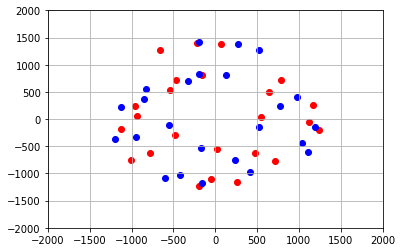

In [12]:
plt.scatter(pos[:,0], pos[:,1], color='red')
plt.scatter(pos_i[:,0], pos_i[:,1], color='blue')

plt.xlim(-2000,2000)
plt.ylim(-2000,2000)
plt.grid(True)
plt.show()

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [13]:
result = np.zeros((n_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

array([[-0.467,  0.717,  0.   ],
       [-0.16 ,  0.81 ,  0.   ],
       [-0.538,  0.544,  0.   ],
       [ 0.066,  1.372,  0.   ],
       [-0.654,  1.262,  0.   ],
       [-0.213,  1.394,  0.   ],
       [ 1.118, -0.057,  0.   ],
       [ 1.172,  0.26 ,  0.   ],
       [ 1.245, -0.203,  0.   ],
       [ 0.785,  0.719,  0.   ],
       [ 0.546,  0.038,  0.   ],
       [ 0.64 ,  0.49 ,  0.   ],
       [-0.053, -1.11 ,  0.   ],
       [ 0.255, -1.165,  0.   ],
       [-0.198, -1.231,  0.   ],
       [ 0.715, -0.768,  0.   ],
       [ 0.021, -0.55 ,  0.   ],
       [ 0.473, -0.625,  0.   ],
       [-0.932,  0.06 ,  0.   ],
       [-1.128, -0.176,  0.   ],
       [-0.962,  0.246,  0.   ],
       [-1.005, -0.756,  0.   ],
       [-0.483, -0.29 ,  0.   ],
       [-0.778, -0.628,  0.   ]])

In [14]:
json_result = {}
json_result["antenna_positions"] = result.tolist()
print(json.dumps(json_result, indent=4, separators=(',', ': ')))

{
    "antenna_positions": [
        [
            -0.467,
            0.717,
            0.0
        ],
        [
            -0.16,
            0.81,
            0.0
        ],
        [
            -0.538,
            0.544,
            0.0
        ],
        [
            0.066,
            1.372,
            0.0
        ],
        [
            -0.654,
            1.262,
            0.0
        ],
        [
            -0.213,
            1.394,
            0.0
        ],
        [
            1.118,
            -0.057,
            0.0
        ],
        [
            1.172,
            0.26,
            0.0
        ],
        [
            1.245,
            -0.203,
            0.0
        ],
        [
            0.785,
            0.719,
            0.0
        ],
        [
            0.546,
            0.038,
            0.0
        ],
        [
            0.64,
            0.49,
            0.0
        ],
        [
            -0.053,
            -1.11,
            0.0
    

The position file above is in a format suitable for uploading to the telescope api. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.